**ADMM迭代算法实验记录**

In [ ]:

from dataset.SpectralDataset import SpectralDataset
from net.model_ADMM import ADMM
import torch
import matplotlib.pylab as plt
import random

sp ="data/SpectralResponse_9_256.npy"   


plt.rcParams['figure.figsize'] = (16, 8.0) 
sigs = [10, 20, 30, 50, 100, 200, 300, 500]
col = len(sigs)//2
iter = 1000
print("iter : ", iter)
plt.figure()
fig, ax = plt.subplots(2,col)
for i in range(2):
    for j in range(col):
        idx = i * col + j
        random.seed(100)
        dataset = SpectralDataset(sp, train=True, have_noise=False, sig=(sigs[idx],sigs[idx]+1), peak_num=1)
        det, spectral = dataset.__getitem__(1)
        sz = dataset.get_size()
        x = torch.linspace(355,3735,sz[0])

        admm = ADMM(mode="l1_tv", iter = iter, sp_file = sp)
        rex = admm.forward(spectral)
        ax[i][j].plot(x, spectral,'b', x, rex,'r:') 
        ax[i][j].set_title("sigma:{}".format(sigs[idx]))  
plt.show()


**ADMM-Net效果测试**

512 9
epoch 55


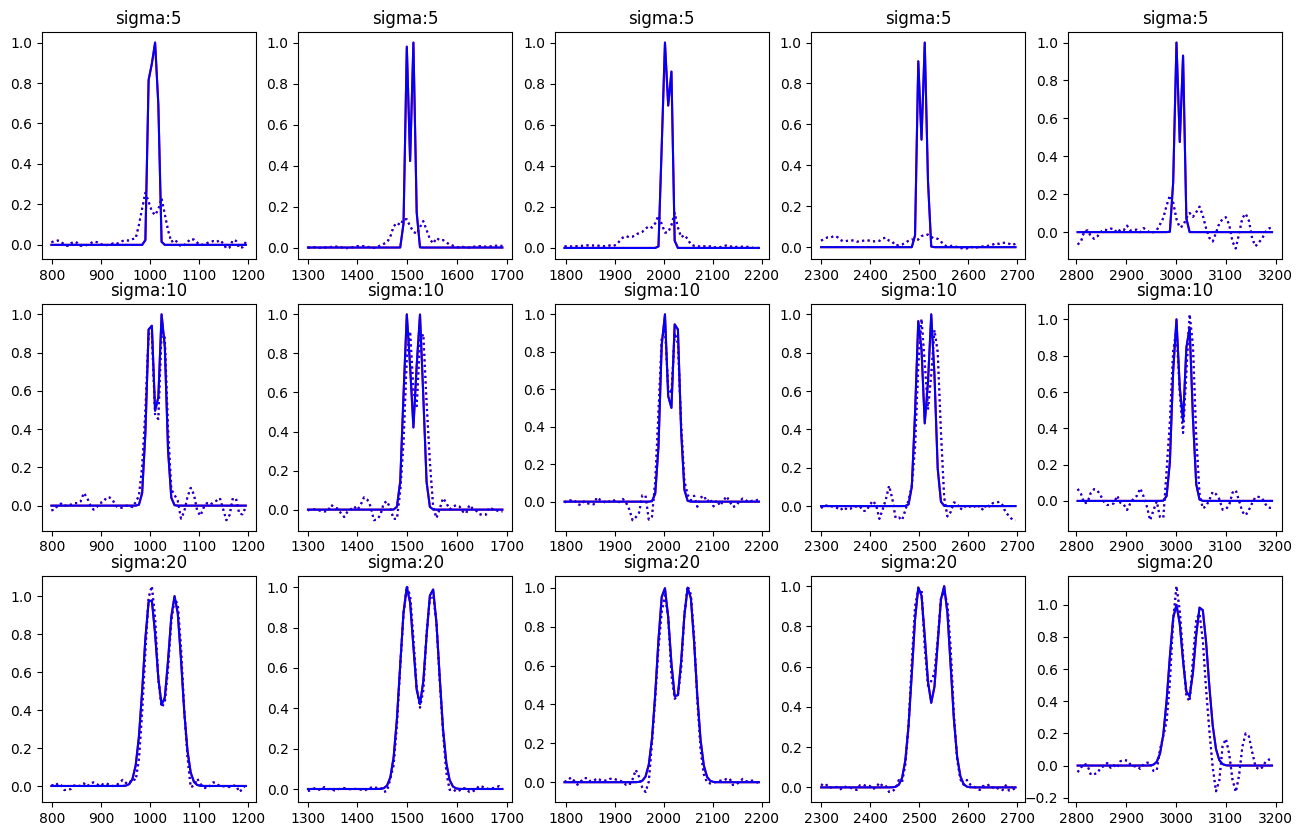

In [4]:
from net.model_LADMM import LADMM
import torch
import matplotlib.pylab as plt
import random
import numpy as np
import collections

def curve(sp, x, center, sigma, double=False):
    spectral = np.exp(-1 * (x - center)**2 / (sigma**2 ))
    if double:
        spectral += np.exp(-1 * (x - center - sigma * 2.5 )**2 / (sigma**2 ))
    spectral = spectral / np.max(spectral)
    det = np.matmul(spectral, sp)
    return spectral, det

sp_file ="data/SpectralResponse_9_512.npy"   
admm = LADMM(mode="l1_tv_cnn", sp_file = sp_file, iter = 50,has_res=True)

sp = np.load(sp_file)
length, det_num = sp.shape
print(length, det_num)

model_path = "debug/20230614063132/spectral_fc_01.pth"
dict = torch.load(model_path, map_location=torch.device('cpu'))
print("epoch",dict['epoch'])
new_state_dict = collections.OrderedDict()
for k, v in dict["state_dict"].items():
    name = k[7:] # remove 'module.' prefix
    new_state_dict[name] = v
admm.load_state_dict(new_state_dict)
admm.eval()


cnts = [1000, 1500, 2000, 2500, 3000]
sigs = [5,10,20]
plt.rcParams['figure.figsize'] = (16.0, 10.0) 

fig, ax = plt.subplots(len(sigs), len(cnts))
for i, cnt in enumerate(cnts) :
    for j, sig in enumerate(sigs):
        x = np.linspace(355,3735, length)

        center1 = cnt
        center2 = center1 
        sigma = sig

        c1, det1 = curve(sp, x, center1, sigma, True)
        det1 = torch.tensor(det1).unsqueeze(0).float()

        c2, det2 = curve(sp, x, center2, sigma, True)
        det2 = torch.tensor(det2).unsqueeze(0).float()

        pred1 = admm(det1, torch.tensor(c1).unsqueeze(0).float())
        cs1 = pred1.squeeze(0).detach().numpy()

        pred2 = admm(det2,  torch.tensor(c2).unsqueeze(0).float())
        cs2 = pred2.squeeze(0).detach().numpy()

        cent = (center1 + center2 )/2
        start = int(length * (cent - 200 - 355 ) / (3735 - 355))
        end = int(length * (cent + 200 - 355 ) /(3735 - 355))

        x = x[start:end]
        c1 = c1[start:end]
        c2 = c2[start:end]
        cs1 = cs1[start:end]
        cs2 = cs2[start:end]    
        ax[j][i].plot(x,c1,"r", x,cs1,"r:", x,c2,"b", x,cs2,"b:") 
        ax[j][i].set_title("sigma:{}".format(sig))  
        # ax[j][i].set_title("sigma:{}, diff:{}".format(sig,int((cs2.argmax() - cs1.argmax()) * (3735 - 355) / length)))  

plt.show()
